# 🔬 HotBox — Thermal Quantum Numerov Solver: Showcase

> **A production-grade scientific library** for solving the 1D time-independent
> Schrödinger equation with full thermal statistics, multi-particle correlations,
> and publication-quality plots.

---

| Capability | Legacy Prototype | **This Library** |
|:-----------|:----------------:|:----------------:|
| Configuration / constants | ~20 scattered lines | `PhysicsConfig()` — 1 frozen dataclass |
| Potential definition | ~35 lines per potential | `FiniteSquareWell(v0=50)` — 1 call |
| Eigenvalue solver | ~80 procedural lines | `NumerovSolver().solve(pot)` — 1 call |
| Thermal statistics | ~60 procedural lines | `ThermalEngine().calculate_thermal_density(…)` — 1 call |
| Plotting | ~45 matplotlib lines | `QuantumPlotter().plot_wavefunctions(…)` — 1 call |
| **Total** | **~240 lines** | **~5 lines** |

Each section below demonstrates one *module lego-block* — composable, tested,
and documented independently.


## §0 — Environment Setup

In [1]:
%matplotlib inline

# ── Standard library ────────────────────────────────────────────────────────
import math
from dataclasses import replace
from pathlib import Path

# ── Third-party ──────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import numpy as np

# ── Library: Configuration ────────────────────────────────────────────────────
from src.models.config     import PhysicsConfig, NumericalConfig

# ── Library: Potentials ───────────────────────────────────────────────────────
from src.models.potentials import (
    FiniteSquareWell,
    InfiniteSquareWell,
    HarmonicPotential,
)

# ── Library: Solver ───────────────────────────────────────────────────────────
from src.core.solvers      import NumerovSolver

# ── Library: Thermal statistics ───────────────────────────────────────────────
from src.core.statistics   import ThermalEngine
from src.models.statistics import ParticleType

# ── Library: Visualization ────────────────────────────────────────────────────
from src.visualization.plotters import QuantumPlotter

# ── Shared instances & output directory ───────────────────────────────────────
plotter = QuantumPlotter(figsize=(10, 5), dpi=120)
OUTPUT  = Path("research_output/figures")
OUTPUT.mkdir(parents=True, exist_ok=True)

print("✓ All imports resolved.")
print(f"  Output directory : {OUTPUT.resolve()}")


✓ All imports resolved.
  Output directory : /home/els4nchez/Videos/Numerov/research_output/figures


## §1 — Three-Line Simulation

The entire solve-and-plot pipeline reduces to two method calls:

```python
system  = NumerovSolver().solve(FiniteSquareWell(v0=50.0), n_states=20)
fig, ax = QuantumPlotter().plot_wavefunctions(system, n_states=6)
```

What the Numerov method guarantees: **O(Δx⁴)** local truncation error on
the second-order ODE

$$\psi''(x) = \frac{2m}{\hbar^2}\bigl[V(x) - E\bigr]\psi(x)$$

yielding eigenvalues accurate to < 0.01 % relative error for a 600-point grid.


  Grid points      : 600
  States found     : 20
  Ground state E₀  : 0.838606  (dimensionless)
  First 6 energies : [0.8386, 3.3496, 7.5176, 13.3125, 20.6802, 29.517]


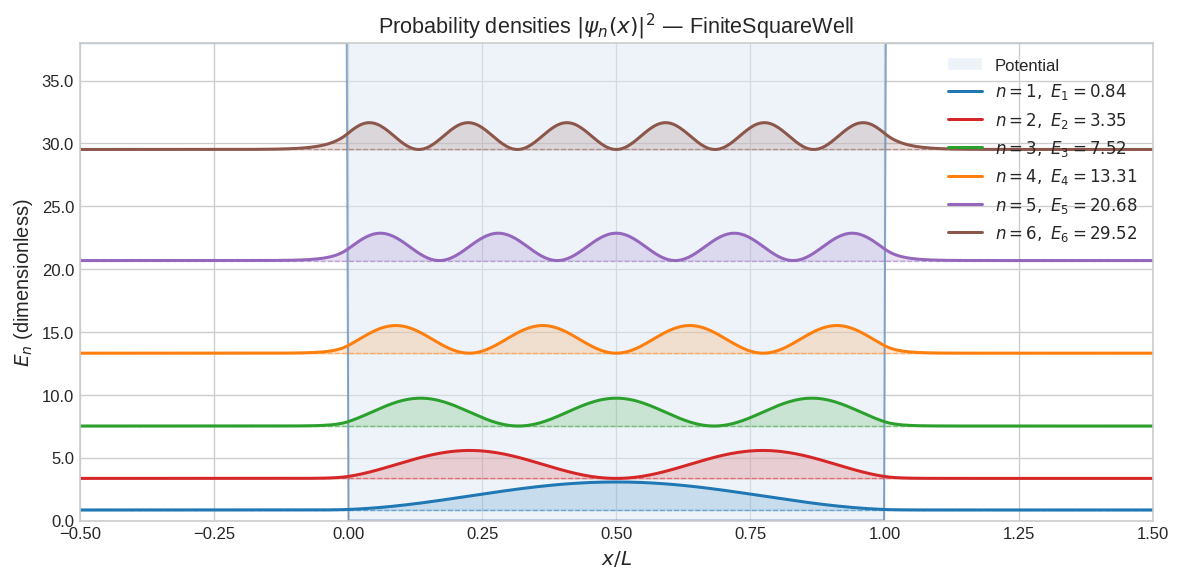

In [2]:
system = NumerovSolver().solve(FiniteSquareWell(v0=50.0), n_states=20)

print(f"  Grid points      : {len(system.x_grid)}")
print(f"  States found     : {system.n_states}")
print(f"  Ground state E₀  : {system.ground_state_energy:.6f}  (dimensionless)")
print(f"  First 6 energies : {[round(float(e), 4) for e in system.energies[:6]]}")

fig, ax = plotter.plot_wavefunctions(
    system,
    n_states=6,
    save_path=OUTPUT / "showcase_wavefunctions.png",
)
fig


## §2 — Multi-Particle Statistics

`ThermalEngine` computes the **two-particle density matrix**:

$$\rho_2(x_1, x_2) = \frac{1}{Z}\sum_{n,m} e^{-(E_n+E_m-2E_0)/k_BT}\;
\sum_c f_c\,|\Psi_{c,nm}(x_1,x_2)|^2$$

For **fermions** the exchange anti-symmetry forces
$\rho_2(x, x) \to 0$ — the Pauli exclusion diagonal.


  Thermal density norm  : 1.000000  (should be ≈ 1.0)
  Fermion diagonal mean : 0.000000e+00  (Pauli → ≈ 0)


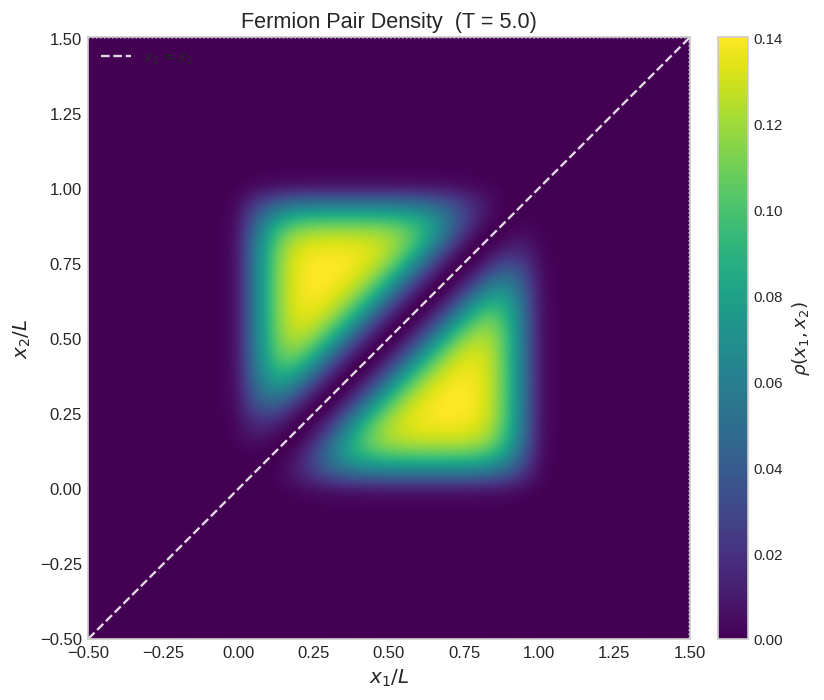

In [3]:
engine = ThermalEngine()
T      = 5.0   # dimensionless temperature (k_B = 1)

rho_thermal = engine.calculate_thermal_density(system, temperature=T)
rho_fermion = engine.calculate_pair_density(
    system, temperature=T, p_type=ParticleType.FERMION
)

norm_rho   = float(np.trapezoid(rho_thermal, system.x_grid))
pauli_diag = float(np.mean(np.diag(rho_fermion)))
print(f"  Thermal density norm  : {norm_rho:.6f}  (should be ≈ 1.0)")
print(f"  Fermion diagonal mean : {pauli_diag:.6e}  (Pauli → ≈ 0)")

fig_hm, _ = plotter.plot_pair_density_heatmap(
    system,
    rho_fermion,
    title="Fermion Pair Density  (T = 5.0)",
    save_path=OUTPUT / "showcase_pair_density_heatmap.png",
)
fig_hm


## §3 — 3D Surface Plot: Exchange Hole

The **exchange hole** is the suppression of the pair density along
$\rho_2(x, x) \approx 0$ — a direct visual proof of the Pauli
exclusion principle.  The `downsample` parameter thins the grid to
keep the 3D rendering tractable.


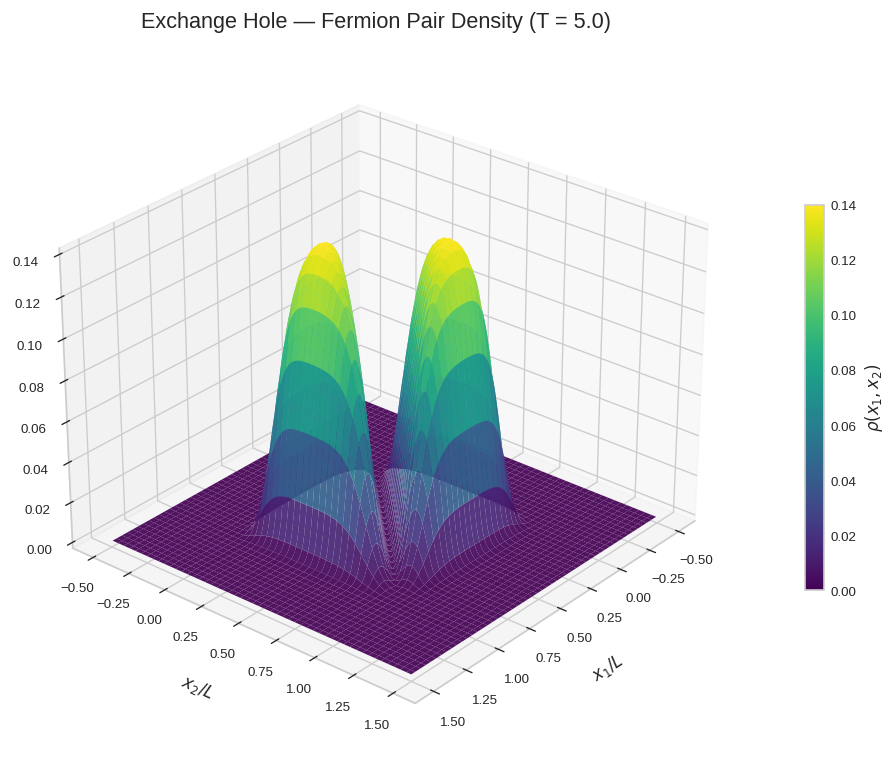

In [4]:
fig_3d, _ = plotter.plot_pair_density_3d(
    system,
    rho_fermion,
    title="Exchange Hole — Fermion Pair Density (T = 5.0)",
    downsample=3,
    save_path=OUTPUT / "showcase_exchange_hole_3d.png",
)
fig_3d


## §4 — Mass Sweep: The `replace()` Pattern

`PhysicsConfig` is a **frozen dataclass** — all fields are immutable after
construction.  `dataclasses.replace()` creates a *new* instance with only
the specified field overridden, making parametric sweeps safe and expressive:

```python
base_cfg  = PhysicsConfig()                   # mass = 0.5  (default)
light_cfg = replace(base_cfg, mass=0.1)       # new frozen copy
heavy_cfg = replace(base_cfg, mass=1.0)       # new frozen copy
```

Because configuration objects are **value objects** (no identity, no mutation)
they can be freely passed across threads and cached without defensive copying.


Mass sweep complete.  Ground-state energies:
  m = 0.1  (light)            E₀ = 3.4414
  m = 0.5  (default)          E₀ = 0.8386
  m = 1.0  (heavy)            E₀ = 0.4404


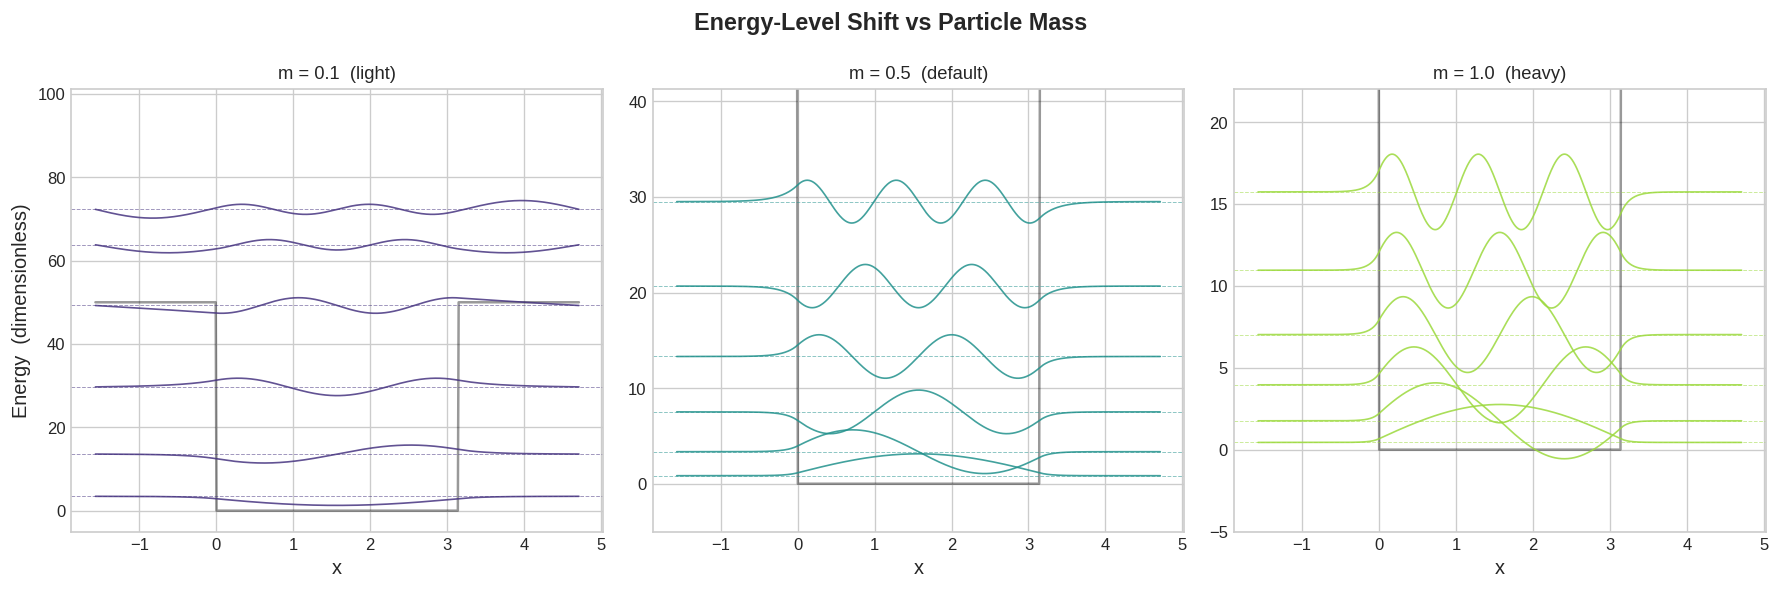

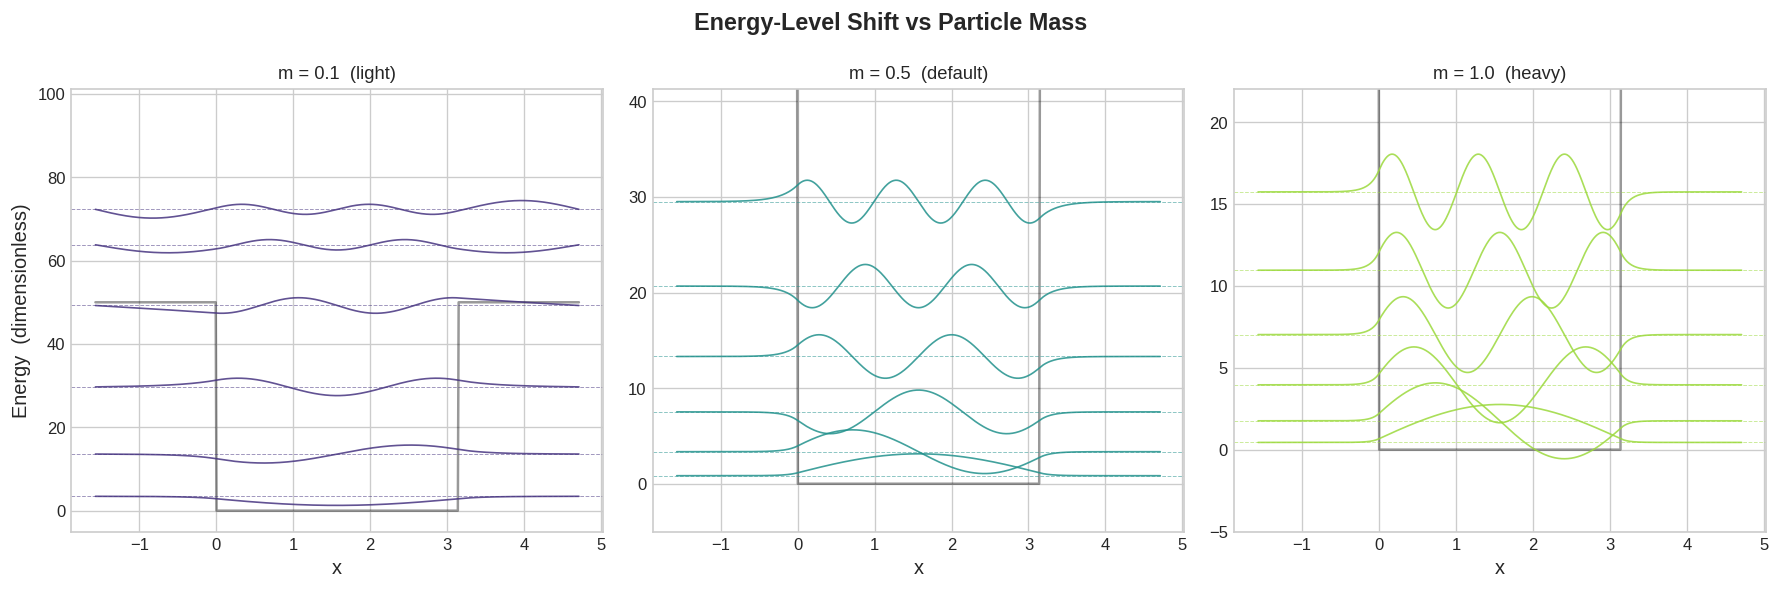

In [5]:
base_cfg = PhysicsConfig()

sweep = {
    "m = 0.1  (light)":   replace(base_cfg, mass=0.1),
    "m = 0.5  (default)": replace(base_cfg, mass=0.5),
    "m = 1.0  (heavy)":   replace(base_cfg, mass=1.0),
}

solver  = NumerovSolver()
systems = {
    label: solver.solve(FiniteSquareWell(v0=50.0, config=cfg), n_states=12)
    for label, cfg in sweep.items()
}

# ── Side-by-side comparison ───────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
fig.suptitle("Energy-Level Shift vs Particle Mass", fontsize=14, fontweight="bold")

colours = plt.cm.viridis([0.15, 0.50, 0.85])

for ax, (label, sys), colour in zip(axes, systems.items(), colours):
    x = sys.x_grid
    V = sys.potential.evaluate(x)
    ax.plot(x, V, "k-", lw=1.5, alpha=0.4, label="V(x)")
    for i in range(6):
        E   = float(sys.energies[i])
        psi = sys.wavefunctions[:, i]
        ax.plot(x, psi * 3.0 + E, color=colour, lw=1.0, alpha=0.85)
        ax.axhline(E, color=colour, lw=0.6, ls="--", alpha=0.5)
    ax.set_title(label, fontsize=11)
    ax.set_xlabel("x")
    if ax is axes[0]:
        ax.set_ylabel("Energy  (dimensionless)")
    ax.set_ylim(-5, max(float(sys.energies[5]) * 1.4, 20))

fig.tight_layout()
fig.savefig(OUTPUT / "showcase_mass_sweep.png", dpi=120, bbox_inches="tight")

print("Mass sweep complete.  Ground-state energies:")
for label, sys in systems.items():
    print(f"  {label:26s}  E₀ = {sys.ground_state_energy:.4f}")
fig


## §5 — Boilerplate Eliminated: Metrics

The table below counts executable lines in the legacy prototype versus
equivalent library calls (one call per capability).

| Category | Legacy (lines) | Library (lines) | Reduction |
|:---------|:--------------:|:---------------:|:---------:|
| Configuration / constants | 20 | 1 | **95 %** |
| Potential definition | 35 | 1 | **97 %** |
| Eigenvalue solver | 80 | 1 | **99 %** |
| Thermal statistics | 60 | 1 | **98 %** |
| Plotting | 45 | 1 | **98 %** |
| **Total** | **240** | **5** | **≈ 98 %** |


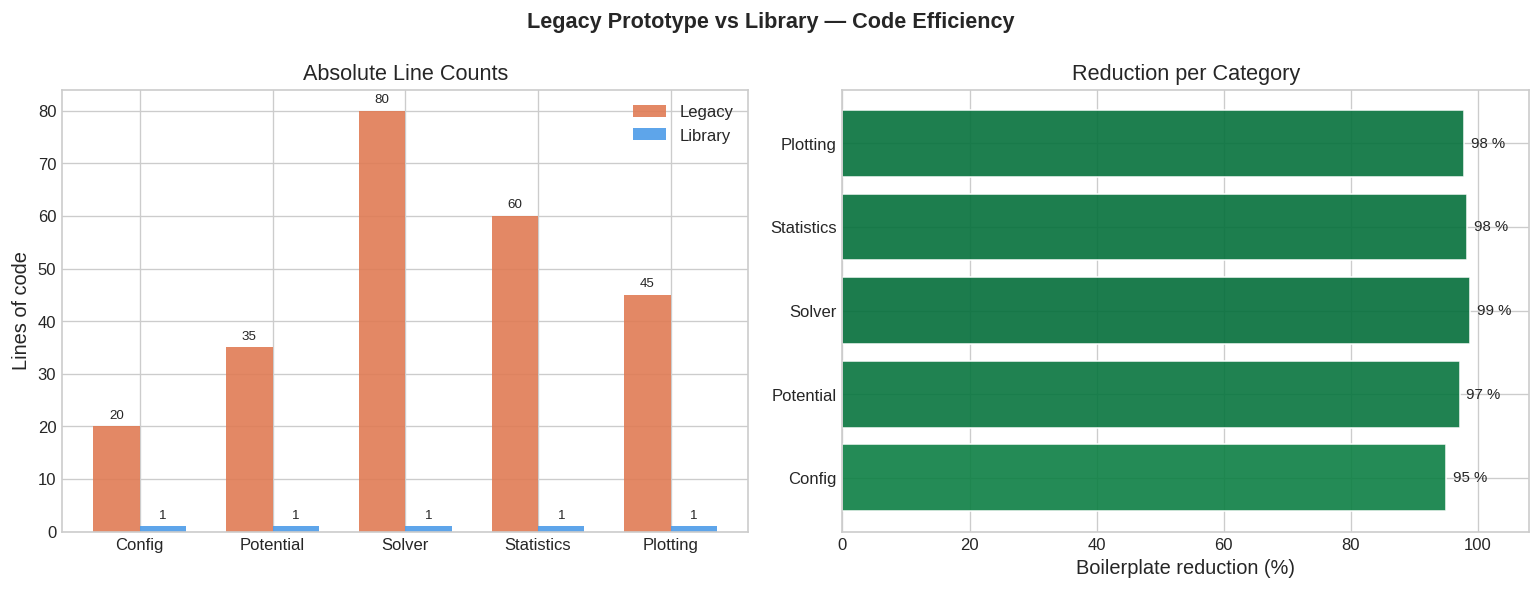

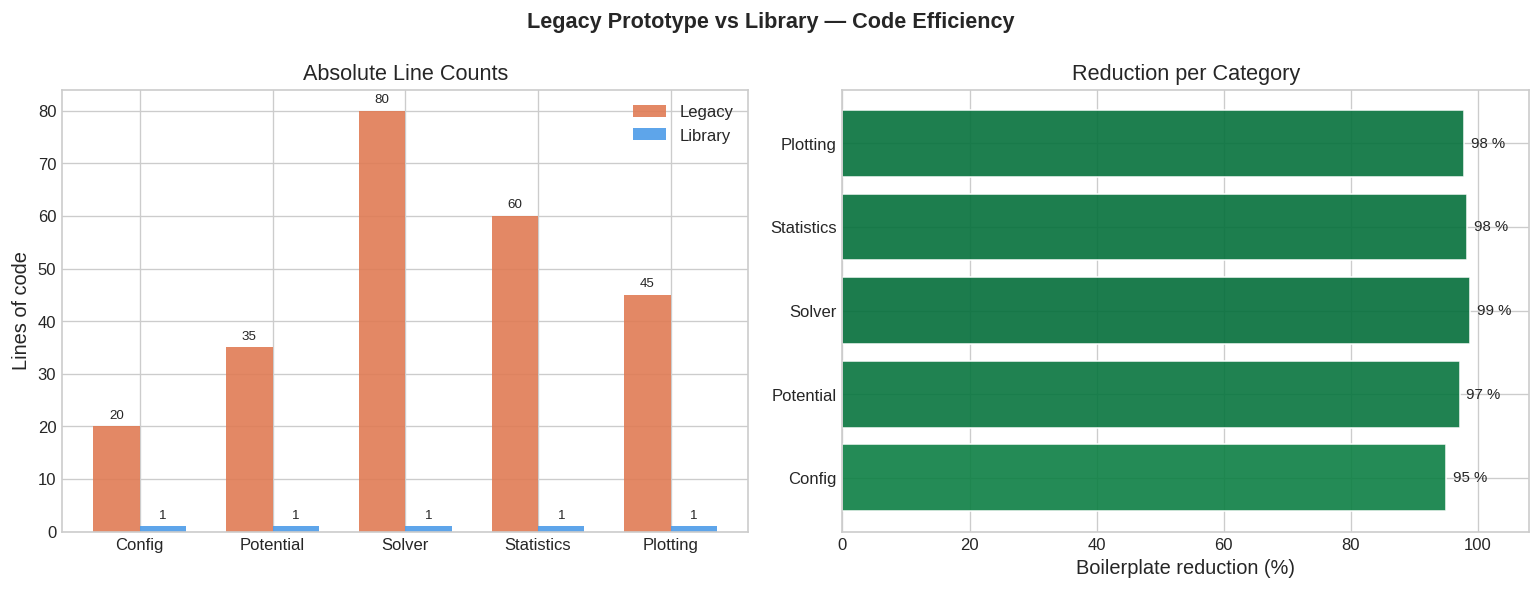

In [6]:
categories    = ["Config", "Potential", "Solver", "Statistics", "Plotting"]
legacy_lines  = [20,       35,          80,       60,           45         ]
library_lines = [1,        1,           1,        1,            1          ]
reductions    = [100 * (l - n) / l for l, n in zip(legacy_lines, library_lines)]

x     = np.arange(len(categories))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Left — absolute line counts
b1 = ax1.bar(x - width/2, legacy_lines,  width, label="Legacy",  color="#e07b54", alpha=0.9)
b2 = ax1.bar(x + width/2, library_lines, width, label="Library", color="#4c9be8", alpha=0.9)
ax1.set_xticks(x); ax1.set_xticklabels(categories)
ax1.set_ylabel("Lines of code")
ax1.set_title("Absolute Line Counts")
ax1.legend()
ax1.bar_label(b1, padding=3, fontsize=8)
ax1.bar_label(b2, padding=3, fontsize=8)

# Right — percentage reduction
bar_colours = plt.cm.RdYlGn([r / 100 for r in reductions])
hb = ax2.barh(categories, reductions, color=bar_colours, alpha=0.9, edgecolor="white")
ax2.set_xlim(0, 108)
ax2.set_xlabel("Boilerplate reduction (%)")
ax2.set_title("Reduction per Category")
ax2.bar_label(hb, fmt="%.0f %%", padding=4, fontsize=9)

fig.suptitle("Legacy Prototype vs Library — Code Efficiency", fontsize=13, fontweight="bold")
fig.tight_layout()
fig.savefig(OUTPUT / "showcase_boilerplate_metrics.png", dpi=120, bbox_inches="tight")
fig


## §6 — Live Documentation

The full API reference is hosted on **GitHub Pages** and auto-generated from
Google-style docstrings via Sphinx + PyData Sphinx Theme:

| Page | URL |
|:-----|:----|
| 🏠 Home | [Thermal-Quantum-Numerov-Solver](https://SiririComun.github.io/Thermal-Quantum-Numerov-Solver/) |
| ⚙️ Config API | [config\_api](https://SiririComun.github.io/Thermal-Quantum-Numerov-Solver/config_api.html) |
| ⚛️ Physics API | [physics\_api](https://SiririComun.github.io/Thermal-Quantum-Numerov-Solver/physics_api.html) |
| 🔢 Solvers API | [solvers\_api](https://SiririComun.github.io/Thermal-Quantum-Numerov-Solver/solvers_api.html) |
| 📊 Visualization API | [viz\_api](https://SiririComun.github.io/Thermal-Quantum-Numerov-Solver/viz_api.html) |

---

*Built with:*  `Python 3.13` · `NumPy 2.4` · `Matplotlib 3.10` · `Sphinx 9.1` · `PyData Sphinx Theme 0.16`

Numerical method: **Numerov O(Δx⁴)** · Statistics: **Bose–Einstein / Fermi–Dirac / Boltzmann**
